### Script to generate FATES parameters using LHS

In [27]:
from scipy.stats import qmc
import numpy as np
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re
import modp as mp
from matplotlib import pyplot as plt
from scipy.io import netcdf as nc
import importlib
import math

In [15]:
pd.set_option('display.max_rows', 500) 

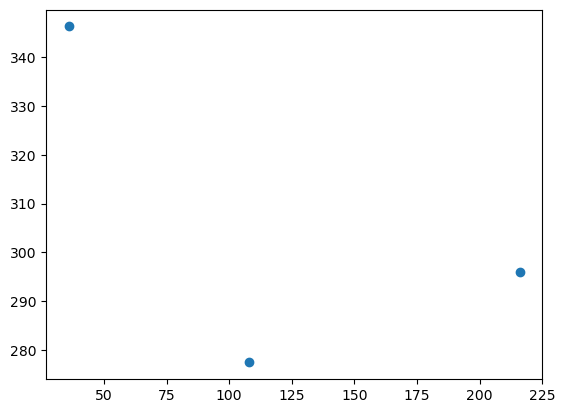

In [32]:
plt.scatter([36,108,216],[346.25,277.46,296])

### Read in min and max values for each parameter and pft 
- Adapted from work by Rachel Ward (parameter ranges and inequalities). 
- Where there are inequalities between PFTx and PFTy, sample PFTx parameter and then use a scalar to generate PFTy parameter. -- If parameter ranges are the same ignore the inequality
- Add some noise to the inequalities so that inter-PFT trait correlations are not too strict

### Pre-process param ranges file

In [28]:
#path_to_ca_fates = '/home/adam/cloud/gdrive/postdoc/california-fates'
path_to_ca_fates = '/glade/u/home/adamhb/california-fates'
#path_to_base_param_files_root = '/home/adam/cloud/gdrive/postdoc/parameters/'
path_to_base_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25'
#path_to_ensemble_param_files_root = '/home/adam/cloud/gdrive/postdoc/parameters/ensemble_params_test'
path_to_ensemble_param_files_root = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/'

pft_names = ['pine','cedar','fir','shrub','oak']
base_param_file_name = 'ca_5pfts_100223_0152.nc'


param_files_subdir = 'resprout_test_100323'
n_inst = 36

param_ranges_full = pd.read_csv(os.path.join(path_to_ca_fates,'parameter_ranges/param_range_archive/param_ranges_resprout_test_100323.csv'))
param_ranges_full = param_ranges_full[['param', 'value_min', 'value_max', 'pft', 'organ']]

# Filter to params that we are going to sample from the LHS
param_ranges = param_ranges_full

# Make sure min and max are floats
convert_dict = {'value_min': float,
                'value_max': float
                }
param_ranges = param_ranges.astype(convert_dict)

# number of parameters
n_params = len(param_ranges)
print("Number of params:",n_params)

# number of PFTs - some are global so subtract one
n_pfts = max(len(pd.unique(param_ranges['pft'])) - 1, 1)
print("Number of pfts:", n_pfts)

param_names = list(param_ranges.param)
print("Param names:",param_names)
pfts = list(param_ranges.pft)
organs = list(param_ranges.organ)

param_ranges

Number of params: 6
Number of pfts: 2
Param names: ['fates_fire_nignitions', 'fates_fire_threshold', 'fates_fire_frac_resprout', 'fates_fire_frac_resprout', 'fates_alloc_storage_cushion', 'fates_alloc_storage_cushion']


,param,value_min,value_max,pft,organ
0,fates_fire_nignitions,0.10,3.50,0,NaN
1,fates_fire_threshold,1.00,1700.00,0,NaN
2,fates_fire_frac_resprout,0.05,0.60,4,NaN
3,fates_fire_frac_resprout,0.50,0.99,5,NaN
4,fates_alloc_storage_cushion,1.00,1.85,5,NaN
5,fates_alloc_storage_cushion,1.00,1.85,4,NaN


In [6]:
param_ranges_inequalities = param_ranges_full.loc[param_ranges_full['pft_ineq'] != 'FALSE']

In [7]:
param_ranges

,pft_ineq,param,value_min,value_max,pft,organ
0,FALSE,fates_recruit_seed_alloc_mature,0.040000,0.392860,1,NaN
3,FALSE,fates_recruit_seed_alloc_mature,0.210000,0.530000,4,NaN
4,FALSE,fates_recruit_seed_alloc_mature,0.100000,0.420000,5,NaN
5,FALSE,fates_recruit_seed_dbh_repro_threshold,10.000000,30.000000,1,NaN
8,FALSE,fates_recruit_seed_dbh_repro_threshold,10.000000,30.000000,5,NaN
9,FALSE,fates_fire_alpha_SH,0.100000,0.900000,1,NaN
12,FALSE,fates_fire_alpha_SH,0.100000,0.900000,4,NaN
13,FALSE,fates_fire_alpha_SH,0.100000,0.900000,5,NaN
14,FALSE,fates_fire_bark_scaler,0.020000,0.080000,1,NaN
17,FALSE,fates_fire_bark_scaler,0.005000,0.020000,4,NaN


### Sample the parameter space using a Latin Hypercube approach

In [29]:
sampler = qmc.LatinHypercube(d=n_params, seed=31)
sample = sampler.random(n=n_inst)

# scale to parameter ranges
l_bounds = param_ranges['value_min']
u_bounds = param_ranges['value_max']

scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

print("ensemble dimensions:",scaled_sample.shape)

#Create a dataframe of the LHS ensemble
col_names = [v + "_" + str(p) for v,p in zip(param_names,pfts)]
lhs_df = pd.DataFrame(data=scaled_sample,columns=col_names)

ensemble dimensions: (36, 6)


### Visualize distribution of parameter ranges sampled by the LHS

In [6]:
# if lhs_df.shape[1] < 50:
#    lhs_df.hist(bins=10, figsize=(20,15))
#    plt.show()

### Construct parameter files from the LHS samples

In [7]:
#importlib.reload(mp)

In [31]:
## Read in FATES file with values that will be used for all non-varying parameters

# This parameter file has many changes associated with it compared to the default FATES file
# It also has new parameter added as part of the development required for this experiment.
input_fname = os.path.join(path_to_base_param_files_root,base_param_file_name)

print(input_fname)

# for each sample 
for i in range(0,n_inst) :
    
    param_file_end = str(i+1).rjust(4, '0')
    
    print(param_file_end)
    
    # final parameter file name
    new_file_name = 'ca_5pfts_100323_resprout_{0}.nc'.format(param_file_end)
    fout = os.path.join(path_to_ensemble_param_files_root,param_files_subdir,new_file_name)
    
    shutil.copyfile(input_fname, fout)                                                                                                                             
   
    # loop through each parameter and apply either to the correct pft or globally
    for j in range(0, n_params) : 
        
        var = param_names[j]
        pft = pfts[j]
        organ = organs[j]
        
        val = scaled_sample[i, j]
    
        mp.main(var = var, pft = pft, fin = fout, val = val, 
                    fout = fout, O = 1, organ = organ)

/glade/u/home/adamhb/ahb_params/fates_api_25/ca_5pfts_100223_0152.nc
0001
0002
0003
0004
0005
0006
0007
0008
0009
0010
0011
0012
0013
0014
0015
0016
0017
0018
0019
0020
0021
0022
0023
0024
0025
0026
0027
0028
0029
0030
0031
0032
0033
0034
0035
0036


### Add values that require a pft-inequality

In [10]:
def contains_angle_brackets(s):
    return '<' in s or '>' in s

In [11]:
def get_param_value_from_ineq(ref_pft_value,min_val,max_val,pft_ineq):
    '''returns the parameter value for the pft that depends on a reference pft value'''
    
    if contains_angle_brackets(pft_ineq):
        if ">" in pft_ineq:
            min_val = ref_pft_value
            new_value = np.random.uniform(float(min_val),float(max_val))
        if "<" in pft_ineq:
            max_val = ref_pft_value
            new_value = np.random.uniform(float(min_val),float(max_val))
    else:
        new_value = ref_pft_value
    
    return new_value

def get_ref_pft_index(ineq):  
    for p in pft_names:
        if p in ineq:
            return pft_names.index(p)

def find_files_with_substring(directory, substring):
    """
    Returns a list of filenames in the given directory that contain the given substring.
    
    :param directory: The path to the directory to search in.
    :param substring: The substring to search for in filenames.
    :return: A list of filenames containing the substring.
    """

    # List all files in the directory
    all_files = os.listdir(directory)

    # Filter the ones that contain the substring
    matching_files = [f for f in all_files if substring in f]

    return matching_files


def extract_variable_from_netcdf(file_path, variable_name,pft_index,organ_index):
    """
    Extract a variable from a NetCDF file.

    Parameters:
    - file_path: The path to the NetCDF file.
    - variable_name: The name of the variable to extract.
    - pft index (python index starting at 0)
    - organ index (python index starting at 0)

    Returns:
    - The extracted variable data.
    """
    with nc4.Dataset(file_path, 'r') as dataset:
        # Check if the variable exists in the dataset
        if variable_name in dataset.variables:
            variable_data = dataset.variables[variable_name][:]
            if organ_index == None:
                if len(variable_data.shape) > 1:
                    return variable_data[0,pft_index]
                else:
                    return variable_data[pft_index]
            else:
                return variable_data[organ_index,pft_index]
        else:
            raise ValueError(f"'{variable_name}' not found in the NetCDF file.")

def assign_var_to_nc(file,var,value,pft,organ):
    
    '''
    assigns a value to a netcdf for a particular pft and organ
    
    file = full path to netcdf
    var = fates parameter name
    value = parameter value to add to file
    pft = pft number starting at 1
    organ = organ id starting at 1
    '''
    
    # open nc file
    ncfile = nc.netcdf_file(file, 'a')
    
    # define param of interest
    var = ncfile.variables[var]
    
    # get number of dimensions
    ndim = len(var.dimensions)
    
    if var.dimensions[0] == 'fates_leafage_class':
        #print("using vcmax")
        var[:,int(pft-1)] = value
    
    
    else:
        
        # if ndim > 1 then we have pft and organ
        if ndim > 1:
            #print("using A")
            var[int(organ-1),int(pft-1)] = value

        # if pft = 0 (global), and we specify an organ 
        if (pft == 0) & (not np.isnan(organ)):
            var[(int(organ - 1))] = value
            #print("using B")
        
        # if pft = 0 and organ is NA
        if (pft == 0) & (np.isnan(organ)):
            var[:] = value
            #print("using new one")
        
        # if pft is specified, but organ is not
        if (pft > 0) & (ndim == 1):
            var[(int(pft - 1))] = value
            #print("using C")

### Test

In [11]:
# ref_nc_file = find_files_with_substring(os.path.join(path_to_ensemble_param_files_root,param_files_subdir), "0002")
# print(ref_nc_file[0])
# ref_nc_file_full_path = os.path.join(path_to_ensemble_param_files_root,param_files_subdir,ref_nc_file[0])
# print(ref_nc_file_full_path)

# a = extract_variable_from_netcdf(file_path=ref_nc_file_full_path,
#                              variable_name='fates_frag_maxdecomp',
#                              pft_index=0,organ_index=None)

# a

# with nc4.Dataset(ref_nc_file_full_path, 'r') as dataset:
#     variable_data = dataset.variables["fates_leaf_vcmax25top"][:]
#     print(variable_data[0,0])

In [12]:
param_ranges_inequalities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1 to 99
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pft_ineq   38 non-null     object 
 1   param      38 non-null     object 
 2   value_min  29 non-null     float64
 3   value_max  32 non-null     float64
 4   pft        38 non-null     int64  
 5   organ      5 non-null      float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.1+ KB


In [13]:
#Loop through ensemble members

for inst in range(0,n_inst) :
    
    # Get tag
    param_file_end = str(inst+1).rjust(4, '0')
    
    # Get param file with inst tag
    ref_nc_file = find_files_with_substring(directory=os.path.join(path_to_ensemble_param_files_root,
                                                                   param_files_subdir),
                                            substring=param_file_end)
    
    # Get full path of param file
    ref_nc_file_full_path = os.path.join(path_to_ensemble_param_files_root,param_files_subdir,ref_nc_file[0])
    
    print(ref_nc_file_full_path)

    #Loop through parameters
    for i in param_ranges_inequalities.index:

        # input data from the inequalities df
        d = param_ranges_inequalities.loc[i]
        ref_pft_index = get_ref_pft_index(d['pft_ineq'])
        
        #print(d['param'])
        
        #print(ref_pft_index)

        #case where we want one parameter to be the same as another
        if "fates" in d['pft_ineq']:
            
            #print('Case of fates param same as another')
            
            output_val = extract_variable_from_netcdf(file_path=ref_nc_file_full_path,
                                                      variable_name=d['pft_ineq'],
                                                      pft_index=None, organ_index=None)
            assign_var_to_nc(ref_nc_file_full_path,d['param'],output_val,
                             d['pft'],d['organ'])
        #case where we are directly calculating the value
        elif "FIXED" in d['pft_ineq']:
            
            #print('Case FIXED')
            
            # Calculate parameter value
            # In this case the reference parameter is always
            output_val = extract_variable_from_netcdf(file_path=ref_nc_file_full_path,
                                                      variable_name=d['param'],pft_index=0,
                                                      organ_index=None)
            output_val = output_val * d['value_max']
            
            assign_var_to_nc(ref_nc_file_full_path,d['param'],output_val,d['pft'],d['organ'])
        
        #case where we want an inequality between the pfts
        else:
            
            #print('Case inequality')
            
            if math.isnan(d['organ']):
                organ_index = None
            else:
                organ_index = int(d['organ']-1)
            
            ref_pft_value = extract_variable_from_netcdf(ref_nc_file_full_path, d['param'],
                                                         pft_index=ref_pft_index, organ_index=organ_index)
            
            #print(ref_pft_value)
            #print(d['param'])
            
            output_val = get_param_value_from_ineq(ref_pft_value,min_val = d['value_min'],
                                                   max_val = d['value_max'],pft_ineq = d['pft_ineq'])
            
            assign_var_to_nc(ref_nc_file_full_path,d['param'],output_val,d['pft'],d['organ'])
            #print("\n")

/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0001.nc


/glade/scratch/adamhb/ipykernel_19379/3274503201.py:79: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  ncfile = nc.netcdf_file(file, 'a')


/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0002.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0003.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0004.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0005.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0006.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0007.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0008.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0009.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0010.nc
/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/ca_ahb_5pfts_100223/ca_5pfts_091923_0011.nc
/glade/u/h